<a href="https://colab.research.google.com/github/ibixina/ML/blob/main/torn_stocks_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
lag_h6_filepath = "/content/drive/MyDrive/lag_h6.csv"

In [48]:
import pandas as pd

stockData = pd.read_csv(lag_h6_filepath)
stockData.head()

,Timestamp,Opening Price,High Price,Low Price,Closing Price,No of Shares
0,1725516000,446.00,446.32,444.46,444.73,11857134274
1,1725537600,444.73,444.95,443.89,444.13,11853541059
2,1725559200,444.15,444.91,443.94,444.91,11815521548
3,1725580800,444.94,445.82,444.84,445.54,11813736100
4,1725602400,445.61,445.79,444.43,444.77,11671982060


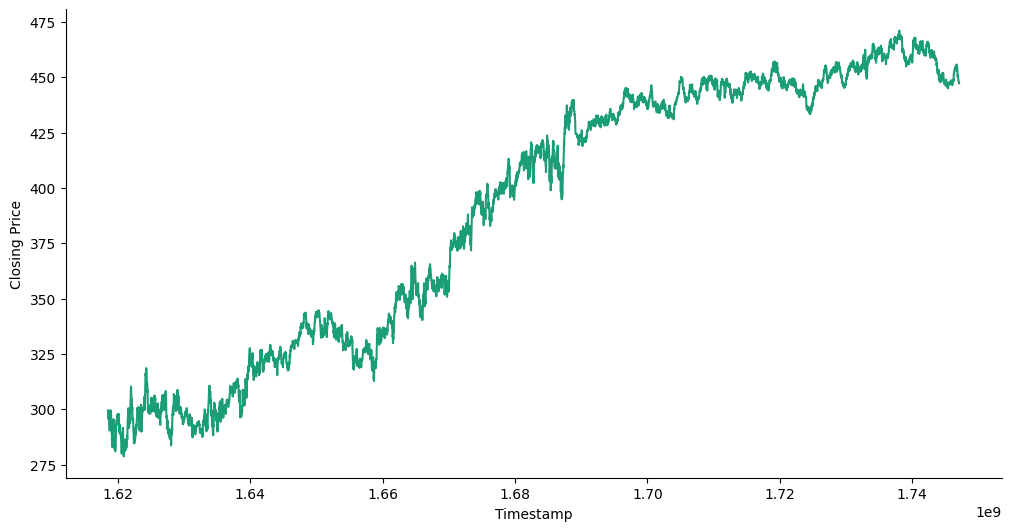

In [3]:
# @title Timestamp vs Closing Price

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Closing Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = stockData.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Closing Price')

In [49]:
# only keep unique timestamps
stockDataCopy = stockData.copy()
stockDataCopy.drop_duplicates(subset=['Timestamp'], inplace=True)
stockDataCopy.shape

(5953, 6)

In [50]:

stockDataCopy["NextValue"] = stockDataCopy["Low Price"].shift(-1)
stockDataCopy.dropna(inplace=True)
print(stockDataCopy.shape)
stockDataCopy.head()

# generate n lags

n_lags = 20
for i in range (1, n_lags + 1):
    stockDataCopy[f"Low Price Lag {i}"] = stockDataCopy["Low Price"].shift(i)
stockDataCopy.dropna(inplace=True)
print(stockDataCopy.shape)
stockDataCopy.head()


(5952, 7)
(5932, 27)


,Timestamp,Opening Price,High Price,Low Price,Closing Price,No of Shares,NextValue,Low Price Lag 1,Low Price Lag 2,Low Price Lag 3,...,Low Price Lag 11,Low Price Lag 12,Low Price Lag 13,Low Price Lag 14,Low Price Lag 15,Low Price Lag 16,Low Price Lag 17,Low Price Lag 18,Low Price Lag 19,Low Price Lag 20
20,1725948000,446.34,447.02,446.21,446.76,8957491044,446.59,446.27,446.83,447.64,...,444.37,443.61,443.03,443.32,444.17,444.43,444.84,443.94,443.89,444.46
21,1725969600,446.74,447.97,446.59,446.97,8957310531,446.96,446.21,446.27,446.83,...,444.70,444.37,443.61,443.03,443.32,444.17,444.43,444.84,443.94,443.89
22,1725991200,447.14,448.06,446.96,447.33,8958681912,446.71,446.59,446.21,446.27,...,445.42,444.70,444.37,443.61,443.03,443.32,444.17,444.43,444.84,443.94
23,1726012800,447.35,448.22,446.71,448.14,8951273819,447.88,446.96,446.59,446.21,...,446.15,445.42,444.70,444.37,443.61,443.03,443.32,444.17,444.43,444.84
24,1726034400,448.14,448.75,447.88,448.01,8948836495,446.78,446.71,446.96,446.59,...,448.23,446.15,445.42,444.70,444.37,443.61,443.03,443.32,444.17,444.43


In [51]:
from sklearn.model_selection import train_test_split

drop = ["Closing Price", "Opening Price", "High Price", "Timestamp", "No of Shares", "NextValue"]
df = stockDataCopy.copy()
X = df.drop(drop, axis=1)
y = df["NextValue"]


train_size = int(len(df) * 0.7)  # 70% for training
train_df = df[:train_size]
test_df = df[train_size:]

X_train = train_df.drop(drop, axis=1)
y_train = train_df["NextValue"]

X_test = test_df.drop(drop, axis=1)
y_test = test_df["NextValue"]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4152, 21) (1780, 21) (4152,) (1780,)


In [17]:
#model a sarima 2,1,3 model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(stockDataCopy["Low Price"], order=(2, 1, 3))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Low Price   No. Observations:                 5952
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -13451.488
Date:                Thu, 22 May 2025   AIC                          26914.977
Time:                        17:08:54   BIC                          26955.125
Sample:                             0   HQIC                         26928.925
                               - 5952                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1545      4.013      0.038      0.969      -7.711       8.020
ar.L2          0.7974      3.905      0.204      0.838      -6.856       8.451
ma.L1         -0.1192      4.013     -0.030      0.9

In [52]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming X_train, y_train, X_test, y_test are already created from the time-based split
# X_train and X_test should contain the lag features and other relevant features

# Reshape the input data for LSTM
# The number of time steps will be the number of lag features (excluding the 'Low Price' itself if it's in X)
# Let's assume X_train and X_test only contain the lag features and potentially other relevant features
# We need to determine the number of features per time step and the number of time steps (sequence length)

# Based on your previous code, X seems to contain "Low Price Lag 1" to "Low Price Lag 10"
# So, the number of time steps is 10, and the number of features per time step is 1 (the Low Price value at that lag)

# Let's verify the number of features in X_train to confirm the number of time steps
num_features = X_train.shape[1] # This should be the number of lag features + other features in X

# If X_train only contains the 'Low Price Lag X' columns (10 of them):
time_steps = num_features
n_features = 1 # One feature (Low Price) per time step in the sequence

# Reshape the data for LSTM
# We need to reshape each sample to be a sequence of time steps, where each time step has 'n_features'
# Current shape of X_train: (samples, num_features) -> e.g., (some_number, 10)
# Desired shape for LSTM: (samples, time_steps, n_features) -> e.g., (some_number, 10, 1)

X_train_lstm = X_train.values.reshape((X_train.shape[0], time_steps, n_features))
X_test_lstm = X_test.values.reshape((X_test.shape[0], time_steps, n_features))

# Reshape y for LSTM (optional, but good practice to have a consistent shape for prediction)
y_train_lstm = y_train.values.reshape((y_train.shape[0], 1))
y_test_lstm = y_test.values.reshape((y_test.shape[0], 1))

print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("y_test_lstm shape:", y_test_lstm.shape)

X_train_lstm shape: (4152, 21, 1)
X_test_lstm shape: (1780, 21, 1)
y_train_lstm shape: (4152, 1)
y_test_lstm shape: (1780, 1)


In [53]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(time_steps, n_features))) # You can adjust the number of LSTM units
model.add(Dense(1)) # Output layer for a single prediction (the next Low Price)

model.compile(optimizer='adam', loss='mse') # Use Adam optimizer and Mean Squared Error loss for regression

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 76807.6797 - val_loss: 50.7892
Epoch 2/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 10.3650 - val_loss: 43.2767
Epoch 3/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 15.5764 - val_loss: 41.1142
Epoch 4/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 26.1666 - val_loss: 39.3710
Epoch 5/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 14.3450 - val_loss: 44.9459
Epoch 6/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 16.3931 - val_loss: 44.0870
Epoch 7/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 20.3948 - val_loss: 67.4978
Epoch 8/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 18.7639 - val_loss: 60.0116
Epoch 9/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 18.4101 - val_loss: 40.4148
Epoch 10/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 11.2859 - val_loss: 36.1662
Epoch 11/300
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 12.5241 - val_loss: 41.7943
Epoch

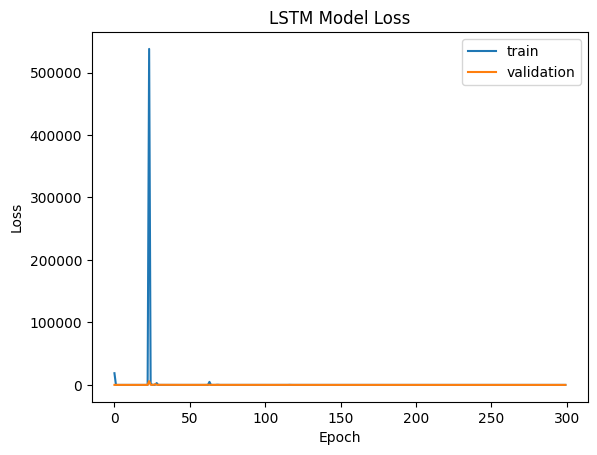

In [54]:
# Train the LSTM model
history = model.fit(X_train_lstm, y_train_lstm, epochs=300, batch_size=10, validation_split=0.2, verbose=1)
# You can adjust epochs, batch_size, and validation_split

# Optional: Plot training history to see loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f'LSTM Test Loss (MSE): {loss}')

# Make predictions on the test set
predictions_lstm = model.predict(X_test_lstm)

# You can compare these predictions to the actual y_test values
# For example, you can calculate RMSE or other metrics on the test set
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy for sqrt

# Calculate MSE and then take the square root to get RMSE
mse_lstm = mean_squared_error(y_test_lstm, predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm) # Take the square root to get RMSE
print(f'LSTM Test RMSE: {rmse_lstm}')

# To predict the next value based on the last sequence in the test set
# Ensure the shape is correct for prediction (1, time_steps, n_features)
last_sequence = X_test_lstm[-1].reshape(1, time_steps, n_features)
next_prediction_lstm = model.predict(last_sequence)
print(f'LSTM Next Prediction: {next_prediction_lstm}')

LSTM Test Loss (MSE): 17.151033401489258
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
LSTM Test RMSE: 4.141380950760817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
LSTM Next Prediction: [[302.2476]]


In [12]:
# test train data
from sklearn.model_selection import train_test_split

drop = ["Closing Price", "Opening Price", "High Price", "Timestamp", "No of Shares", "NextValue"]
df = stockDataCopy.copy()
X = df.drop(drop, axis=1)
y = df["NextValue"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4166, 1) (1786, 1) (4166,) (1786,)


In [13]:
X.head(), y.head()

(   Low Price
 0     444.46
 1     443.89
 2     443.94
 3     444.84
 4     444.43,
 0    443.89
 1    443.94
 2    444.84
 3    444.43
 4    444.17
 Name: NextValue, dtype: float64)

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


model = LinearRegression()
model.fit(x_train, y_train)

# 4. Evaluate the Model
predictions = model.predict(x_test)

# Evaluate using RMSE
rmse = mean_squared_error(y_test, predictions)
print(f'Linear Regression RMSE: {rmse}')

# print model summary
print(model.score(x_test, y_test))
r2 = r2_score(y_test, predictions)
print(f'Linear Regression R2: {r2}')

# predict the next data
next_data = x_test.iloc[-1].values.reshape(1, -1)
next_prediction = model.predict(next_data)
print(f'Next Prediction: {next_prediction}')


Linear Regression RMSE: 1.641857066239578e-11
0.9999999999999956
Linear Regression R2: 0.9999999999999956
Next Prediction: [458.59000044]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
